# Trabajo Final - Redes Neuronales

## Importo las librerias necesarias


In [2]:
from autoencoder import *
from clasificador import *

## Red neuronal autoencoder convolucional de varias capas

### Importo data set

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training data
train_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=True,  transform=transform)
valid_set_orig = datasets.FashionMNIST(
    'MNIST_data/', download=True, train=False, transform=transform)

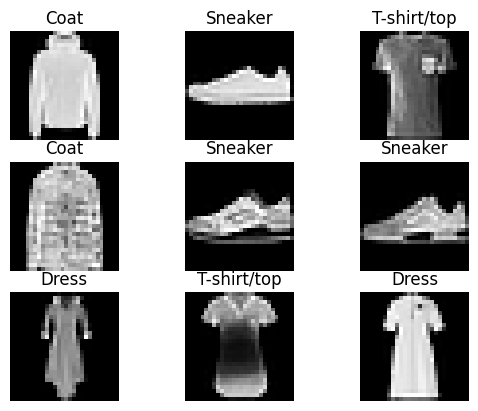

In [27]:
figure = plt.figure()
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    j = torch.randint(len(train_set_orig), size=(1,)).item()
    image, label = train_set_orig[j]
    figure.add_subplot(rows, cols, i)
    plt.title(train_set_orig.classes[label])
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
plt.show()

### Creo data set personalizado

In [4]:
train_set = CustomDataset(train_set_orig)
valid_set = CustomDataset(valid_set_orig)

### Parte 1: red autoencoder

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, n, p=0.2):
        super(Autoencoder, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            # Convolucional 1
            nn.Conv2d(1, 16, kernel_size=3),  # 1x28x28 -> 16x26x26
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2,2), # 16x26x26 -> 16x13x13
            # Convolucional 2
            nn.Conv2d(16, 32, kernel_size=3),  # 16x13x13 -> 32x11x11
            nn.ReLU(),
            nn.Dropout(p),
            nn.MaxPool2d(2, 2),  # 32x11x11 -> 32x5x5
            # Linear
            nn.Flatten(),  # 32x5x5 -> 32*5*5
            nn.Linear(32*5*5, n),  # fully connected 32*5*5 -> n
            nn.ReLU(),
            nn.Dropout(p)
        )
        self.decoder = nn.Sequential(
            # Linear
            nn.Linear(n, 32*5*5),  # fully connected n -> 32*5*5
            nn.ReLU(),
            nn.Dropout(p),
            nn.Unflatten(1, (32, 5, 5)),  # 32*5*5 -> 32x5x5
            # Convolucional transpose (de la segunda convolucional)
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2,
                               output_padding=0, dilation=2),  # 32x5x5 -> 16x13x13
            nn.ReLU(),
            nn.Dropout(p),
            # Convolucional transpose (de la primera convolucional)
            nn.ConvTranspose2d(16, 1, kernel_size=6, stride=2, padding=1,
                               output_padding=0, dilation=1),  # 16x13x13 -> 1x28x28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Modelo sin entrenar

In [6]:
# 2.6)
n = 64
p = 0.2
autoencoder_conv = Autoencoder(n, p)
model = autoencoder_conv

In [7]:
autoencoder_conv.encoder

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=800, out_features=64, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.2, inplace=False)
)

In [8]:
autoencoder_conv.decoder

Sequential(
  (0): Linear(in_features=64, out_features=800, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Unflatten(dim=1, unflattened_size=(32, 5, 5))
  (4): ConvTranspose2d(32, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), dilation=(2, 2))
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): ConvTranspose2d(16, 1, kernel_size=(6, 6), stride=(2, 2), padding=(1, 1))
  (8): Sigmoid()
)

In [9]:
def batch(x):
    return x.unsqueeze(0)  # 28x28 -> 1x28x28


def unbatch(x):
    return x.squeeze().detach().cpu().numpy()  # 1x28x28 -> 28x28

In [34]:
image, _ = train_set[0]
pred = model(batch(image))
print(image.size())
print(unbatch(pred).shape)
print(pred.size())
print(unbatch(pred).shape)

torch.Size([1, 28, 28])
(28, 28)
torch.Size([1, 1, 28, 28])
(28, 28)


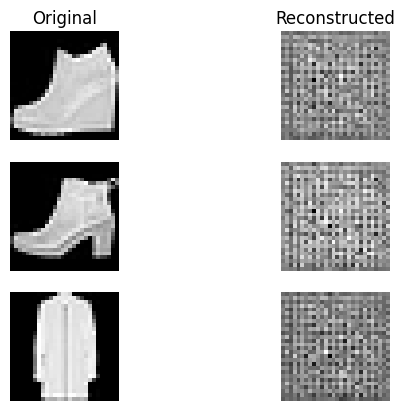

In [35]:
# miramos que imagene predice el modelo sin entrenar
figure = plt.figure()
rows, cols = 3, 2
i = 0
for row in range(1, rows + 1):
    j = torch.randint(len(train_set), size=(1,)).item()
    i += 1
    image, _ = train_set[j]
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Original')
    plt.axis("off")
    plt.imshow(image.squeeze(), cmap="gray")
    i += 1
    figure.add_subplot(rows, cols, i)
    if row == 1:
        plt.title('Reconstructed')
    plt.axis("off")
    image_pred = unbatch(model(batch(image)))
    plt.imshow(image_pred.squeeze(), cmap="gray")
plt.show()

## Parte 2: entrenenado el autoencoder

### Modelo Base

In [12]:
indices = torch.randint(len(valid_set), size=(3,))
indices

tensor([9339, 6352, 9341])

Epoch 1
-------------------------------
batch=0 loss=0.158991  muestras-procesadas:[    0/60000]
batch=100 loss=0.053552  muestras-procesadas:[10000/60000]
batch=200 loss=0.036233  muestras-procesadas:[20000/60000]
batch=300 loss=0.036644  muestras-procesadas:[30000/60000]
batch=400 loss=0.032162  muestras-procesadas:[40000/60000]
batch=500 loss=0.032201  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.028689 

Valid Error: Avg loss: 0.028756 

Epoch 2
-------------------------------
batch=0 loss=0.031934  muestras-procesadas:[    0/60000]
batch=100 loss=0.030538  muestras-procesadas:[10000/60000]
batch=200 loss=0.029503  muestras-procesadas:[20000/60000]
batch=300 loss=0.029156  muestras-procesadas:[30000/60000]
batch=400 loss=0.026173  muestras-procesadas:[40000/60000]
batch=500 loss=0.027472  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.026517 

Valid Error: Avg loss: 0.026606 

Epoch 3
-------------------------------
batch=0 loss=0.028214  muestras-procesad

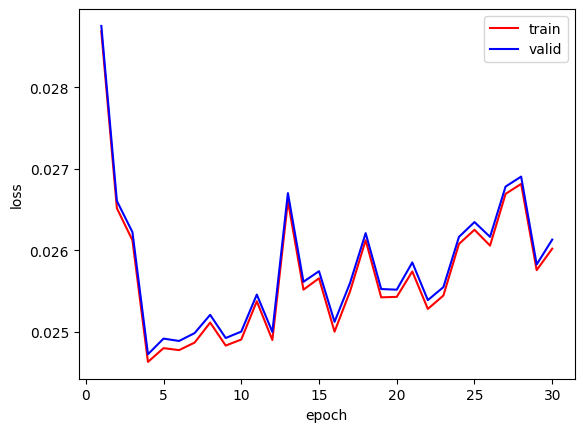

In [37]:
model_orig = model_generator(
    Autoencoder, 64, 0.2, 30, 100, 'Adam', 1e-3, train_set, valid_set)

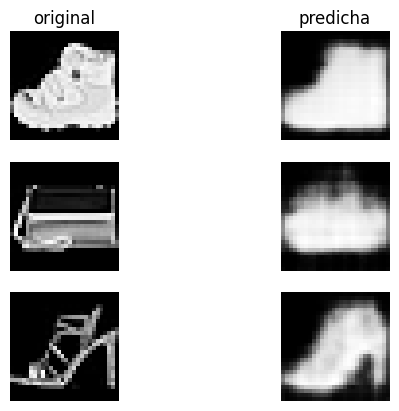

In [38]:
test_model(model_orig, valid_set, indices)

## Variar algunos parametros

### vario dropout

Epoch 1
-------------------------------
batch=0 loss=0.160536  muestras-procesadas:[    0/60000]
batch=100 loss=0.070237  muestras-procesadas:[10000/60000]
batch=200 loss=0.053171  muestras-procesadas:[20000/60000]
batch=300 loss=0.044335  muestras-procesadas:[30000/60000]
batch=400 loss=0.041606  muestras-procesadas:[40000/60000]
batch=500 loss=0.047547  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.051229 

Valid Error: Avg loss: 0.051136 

Epoch 2
-------------------------------
batch=0 loss=0.044412  muestras-procesadas:[    0/60000]
batch=100 loss=0.042606  muestras-procesadas:[10000/60000]
batch=200 loss=0.038530  muestras-procesadas:[20000/60000]
batch=300 loss=0.042413  muestras-procesadas:[30000/60000]
batch=400 loss=0.042217  muestras-procesadas:[40000/60000]
batch=500 loss=0.040466  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.046721 

Valid Error: Avg loss: 0.046584 

Epoch 3
-------------------------------
batch=0 loss=0.037657  muestras-procesad

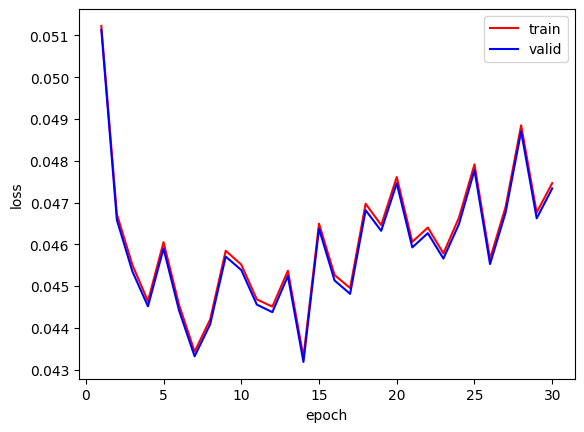

In [39]:
model_drop05 = model_generator(
    Autoencoder, 64, 0.5, 30, 100, 'Adam', 1e-3, train_set, valid_set)

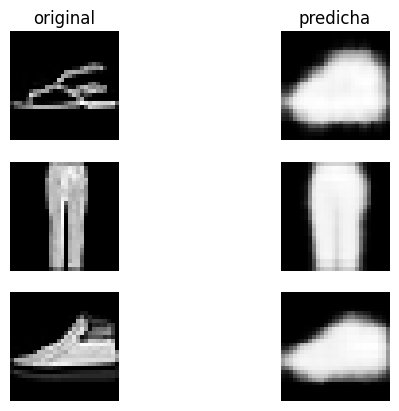

In [40]:
test_model(model_drop05, valid_set)

Epoch 1
-------------------------------
batch=0 loss=0.153482  muestras-procesadas:[    0/60000]
batch=100 loss=0.053013  muestras-procesadas:[10000/60000]
batch=200 loss=0.034337  muestras-procesadas:[20000/60000]
batch=300 loss=0.030025  muestras-procesadas:[30000/60000]
batch=400 loss=0.029717  muestras-procesadas:[40000/60000]
batch=500 loss=0.026515  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.024327 

Valid Error: Avg loss: 0.024438 

Epoch 2
-------------------------------
batch=0 loss=0.028212  muestras-procesadas:[    0/60000]
batch=100 loss=0.025750  muestras-procesadas:[10000/60000]
batch=200 loss=0.025200  muestras-procesadas:[20000/60000]
batch=300 loss=0.025312  muestras-procesadas:[30000/60000]
batch=400 loss=0.025916  muestras-procesadas:[40000/60000]
batch=500 loss=0.024268  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.021795 

Valid Error: Avg loss: 0.021918 

Epoch 3
-------------------------------
batch=0 loss=0.023317  muestras-procesad

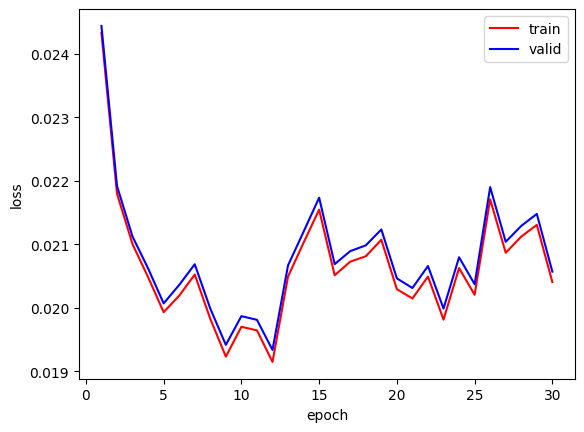

In [41]:
model_64_drop01 = model_generator(
    Autoencoder, 64, 0.1, 30, 100, 'Adam', 1e-3, train_set, valid_set)

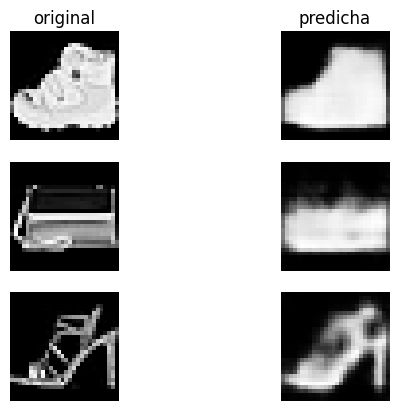

In [42]:
test_model(model_64_drop01, valid_set, indices)

Epoch 1
-------------------------------


batch=0 loss=0.163868  muestras-procesadas:[    0/60000]
batch=100 loss=0.043858  muestras-procesadas:[10000/60000]
batch=200 loss=0.031371  muestras-procesadas:[20000/60000]
batch=300 loss=0.026986  muestras-procesadas:[30000/60000]
batch=400 loss=0.025925  muestras-procesadas:[40000/60000]
batch=500 loss=0.024333  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.021085 

Valid Error: Avg loss: 0.021218 

Epoch 2
-------------------------------
batch=0 loss=0.022589  muestras-procesadas:[    0/60000]
batch=100 loss=0.022836  muestras-procesadas:[10000/60000]
batch=200 loss=0.020671  muestras-procesadas:[20000/60000]
batch=300 loss=0.020378  muestras-procesadas:[30000/60000]
batch=400 loss=0.019460  muestras-procesadas:[40000/60000]
batch=500 loss=0.021626  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.016859 

Valid Error: Avg loss: 0.017013 

Epoch 3
-------------------------------
batch=0 loss=0.020282  muestras-procesadas:[    0/60000]
batch=100 loss=0.020177

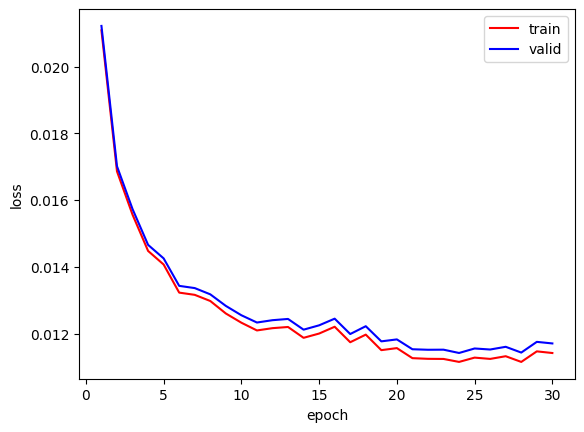

In [10]:
model_256_drop01 = model_generator(
    Autoencoder, 256, 0.1, 30, 100, 'Adam', 1e-3, train_set, valid_set)

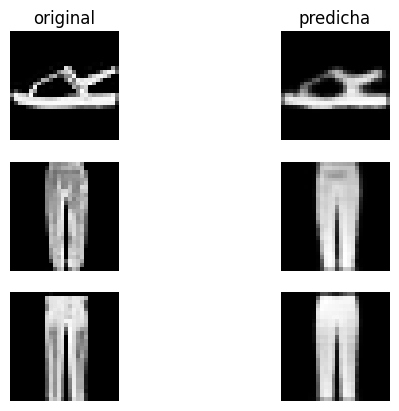

In [13]:
test_model(model_256_drop01, valid_set, indices)

### Variando optimizador

Epoch 1
-------------------------------
batch=0 loss=0.160670  muestras-procesadas:[    0/60000]
batch=100 loss=0.153926  muestras-procesadas:[10000/60000]
batch=200 loss=0.155733  muestras-procesadas:[20000/60000]
batch=300 loss=0.152475  muestras-procesadas:[30000/60000]
batch=400 loss=0.158171  muestras-procesadas:[40000/60000]
batch=500 loss=0.151907  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.153006 

Valid Error: Avg loss: 0.152324 

Epoch 2
-------------------------------
batch=0 loss=0.151770  muestras-procesadas:[    0/60000]
batch=100 loss=0.151519  muestras-procesadas:[10000/60000]
batch=200 loss=0.151891  muestras-procesadas:[20000/60000]
batch=300 loss=0.162110  muestras-procesadas:[30000/60000]
batch=400 loss=0.148309  muestras-procesadas:[40000/60000]
batch=500 loss=0.150514  muestras-procesadas:[50000/60000]
Valid Error: Avg loss: 0.148938 

Valid Error: Avg loss: 0.148277 

Epoch 3
-------------------------------
batch=0 loss=0.149478  muestras-procesad

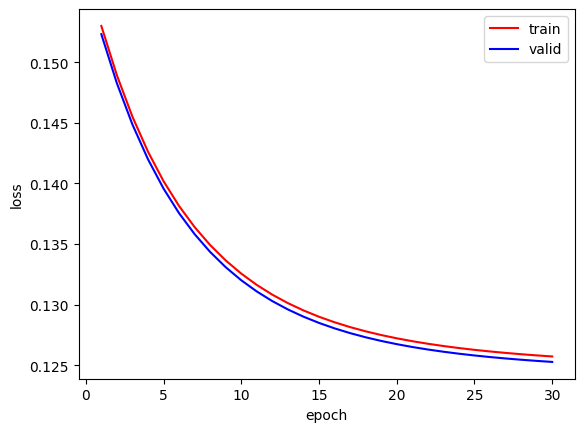

In [43]:
model_drop01_sgd = model_generator(
    Autoencoder, 64, 0.2, 30, 100, 'SGD', 1e-3, train_set, valid_set)

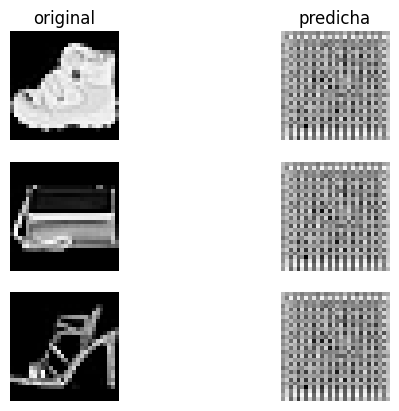

In [44]:
test_model(model_drop01_sgd, valid_set, indices)

## Parte 3: Definiendo un clasificador convolucional reutilizando el encoder

In [45]:
import copy


class Classifier_Conv(nn.Module):
    def __init__(self, n, encoder, p=0.2):
        super(Classifier_Conv, self).__init__()
        self.flatten = nn.Flatten()
        self.encoder = copy.deepcopy(encoder)
        self.classifier = nn.Sequential(
            # Linear
            nn.Linear(n, 10),  # fully connected n -> 32*5*5
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

### clasificador usando el modelo original

Epoch 1
-------------------------------
batch=0 loss=2.487387  muestras-procesadas:[    0/60000]
batch=100 loss=0.801396  muestras-procesadas:[10000/60000]
batch=200 loss=0.573875  muestras-procesadas:[20000/60000]
batch=300 loss=0.792103  muestras-procesadas:[30000/60000]
batch=400 loss=0.593121  muestras-procesadas:[40000/60000]
batch=500 loss=0.624695  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 83.8%, Avg loss: 0.483471 

Test Error: 
 Accuracy: 83.0%, Avg loss: 0.499842 

Epoch 2
-------------------------------
batch=0 loss=0.518054  muestras-procesadas:[    0/60000]
batch=100 loss=0.606310  muestras-procesadas:[10000/60000]
batch=200 loss=0.500743  muestras-procesadas:[20000/60000]
batch=300 loss=0.442355  muestras-procesadas:[30000/60000]
batch=400 loss=0.269775  muestras-procesadas:[40000/60000]
batch=500 loss=0.447879  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.413822 

Test Error: 
 Accuracy: 85.8%, Avg loss: 0.434235 

Epoch 3


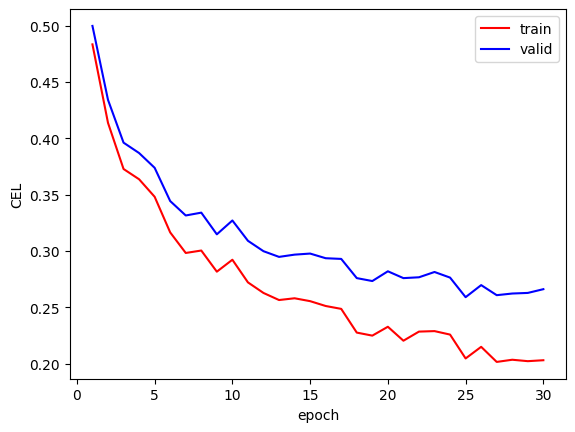

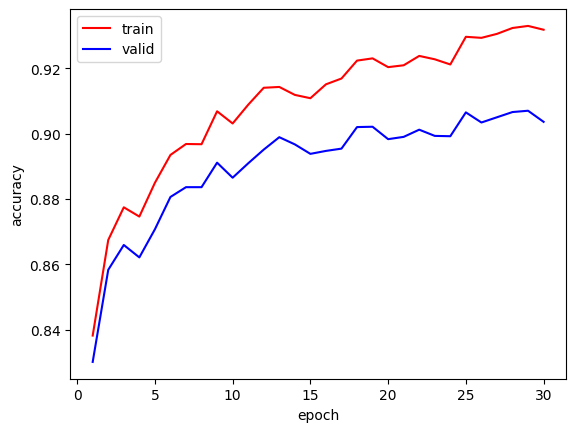

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int8)


              precision    recall  f1-score   support

     T-Shirt       0.82      0.88      0.85      1000
     Trouser       0.99      0.98      0.98      1000
    Pullover       0.80      0.89      0.84      1000
       Dress       0.90      0.90      0.90      1000
        Coat       0.88      0.79      0.83      1000
      Sandal       0.99      0.98      0.99      1000
       Shirt       0.73      0.69      0.71      1000
     Sneaker       0.96      0.98      0.97      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.98      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



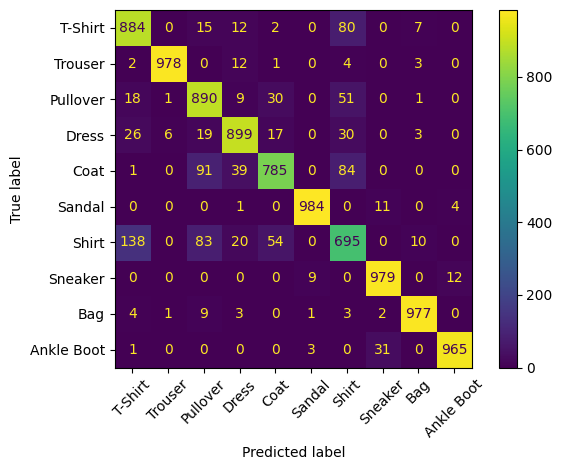

In [46]:
model_classifier_orig = classifier_generator(
    Classifier_Conv, 64, model_orig, 0.2, 30, 100, 'Adam', 1e-3, train_set_orig, valid_set_orig)

## Parte 4:

## Entrenando solo la capa clasificadora

Epoch 1
-------------------------------
batch=0 loss=2.454546  muestras-procesadas:[    0/60000]
batch=100 loss=1.671317  muestras-procesadas:[10000/60000]
batch=200 loss=1.403709  muestras-procesadas:[20000/60000]
batch=300 loss=1.089836  muestras-procesadas:[30000/60000]
batch=400 loss=1.094684  muestras-procesadas:[40000/60000]
batch=500 loss=0.973143  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 71.2%, Avg loss: 1.067810 

Test Error: 
 Accuracy: 70.6%, Avg loss: 1.084913 

Epoch 2
-------------------------------
batch=0 loss=0.946421  muestras-procesadas:[    0/60000]
batch=100 loss=0.842418  muestras-procesadas:[10000/60000]
batch=200 loss=0.771639  muestras-procesadas:[20000/60000]
batch=300 loss=0.778444  muestras-procesadas:[30000/60000]
batch=400 loss=0.958072  muestras-procesadas:[40000/60000]
batch=500 loss=0.730265  muestras-procesadas:[50000/60000]
Test Error: 
 Accuracy: 78.3%, Avg loss: 0.771431 

Test Error: 
 Accuracy: 77.6%, Avg loss: 0.789287 

Epoch 3


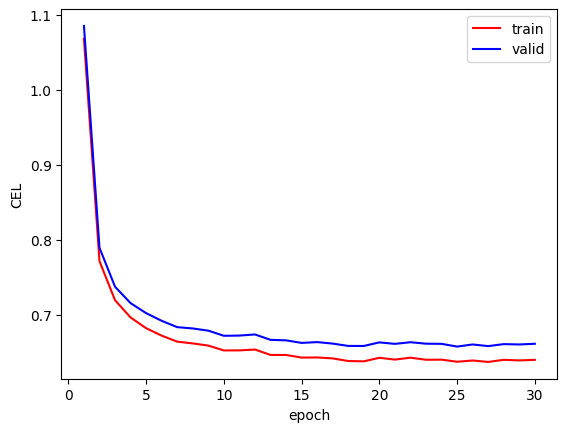

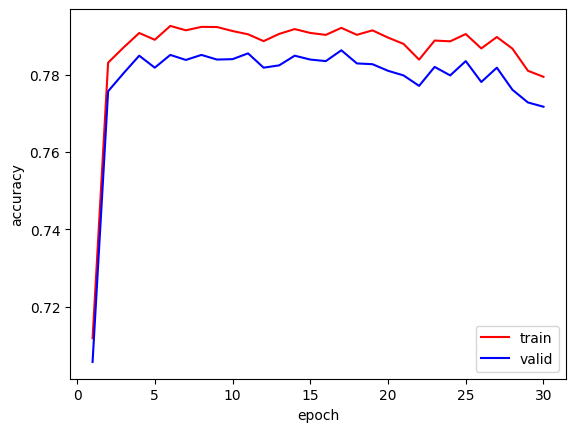

/home/kmansilla/redes-neuronales-trabajos/TP3/clasificador.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.int8)


              precision    recall  f1-score   support

     T-Shirt       0.70      0.84      0.77      1000
     Trouser       0.99      0.93      0.96      1000
    Pullover       0.54      0.73      0.62      1000
       Dress       0.84      0.77      0.80      1000
        Coat       0.75      0.45      0.56      1000
      Sandal       0.97      0.79      0.87      1000
       Shirt       0.41      0.41      0.41      1000
     Sneaker       0.82      0.94      0.87      1000
         Bag       0.93      0.92      0.92      1000
  Ankle Boot       0.90      0.93      0.92      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



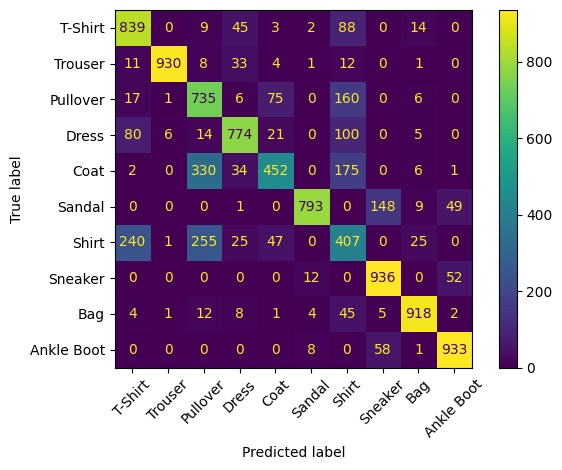

In [47]:
classifier_6 = classifier_generator(Classifier_Conv, 64, model_orig,
                                    0.2, 30, 100, 'Adam classifier', 1e-3, train_set_orig, valid_set_orig)